In [1]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages # add_messages is reducer which only append messages, not replaces

In [2]:
class State(TypedDict):
    messages:Annotated[list, add_messages]  # append messages to list using add_message

In [3]:
import os 
from dotenv import load_dotenv
load_dotenv()

True

In [4]:
# Make LLM
from langchain_groq import ChatGroq
from langchain.chat_models import init_chat_model

llm = ChatGroq(model="llama3-8b-8192")

In [5]:
llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x000001D9796DB020>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x000001D97982A450>, model_name='llama3-8b-8192', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [6]:
# Node functionality -> will recieve input and invoke LLM and append it into message 
def chatbot(state: State):
    return {"messages" : [llm.invoke(state["messages"])]}  

In [7]:
# Building graph
graph_builder = StateGraph(State)

# Adding node
graph_builder.add_node("llmchatbot", chatbot) # starting and name of the chatbot is "llmchatbot"

# Adding edges
graph_builder.add_edge(START, "llmchatbot") # edge from START -> llmchatbot
graph_builder.add_edge("llmchatbot", END) # edge from llmchatbot -> END

# Compile the graph
graph = graph_builder.compile()

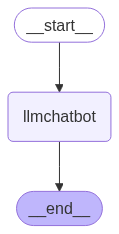

In [8]:
graph

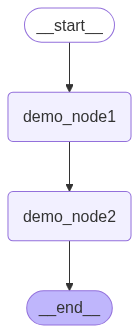

In [9]:
# For PRACTISE
graph_build = StateGraph(State)

# Add node
graph_build.add_node("demo_node1", chatbot)
graph_build.add_node("demo_node2", chatbot)

# Add edges
graph_build.add_edge(START, "demo_node1")
graph_build.add_edge("demo_node1","demo_node2")
graph_build.add_edge("demo_node2",END)

graph_build.compile()

In [10]:
output = graph.invoke({"messages": "Hello"})
answer = output["messages"][-1].content 
print(answer)

Hello! It's nice to meet you. Is there something I can help you with, or would you like to chat?


In [11]:
for event in graph.stream({"messages": "Tell me a joke!"}):
    for value in event.values():
        print(value["messages"][-1].content)

Here's one:

Why couldn't the bicycle stand up by itself?

(Wait for it...)

Because it was two-tired!

Hope that made you smile! Do you want to hear another one?


### Making chatbot with integrating tools :

- When we asks any real-time or live questions to chatbot(LLM), then it is not able to answer the questions.
- We integrate tools with LLM so that LLM can analyze user input and use tools to get output.
- There are two different types of tools we integrate with LLM,
    1) LLM + Bindede tools (ex: DuckDuckGo Search)
    2) Custom function define with Doc string

In [12]:
from langchain_tavily import TavilySearch

tool = TavilySearch(max_results=2)
tool.invoke("What is Langgraph?")

{'query': 'What is Langgraph?',
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'url': 'https://www.datacamp.com/tutorial/langgraph-tutorial',
   'title': 'LangGraph Tutorial: What Is LangGraph and How to Use It?',
   'content': 'LangGraph is a library within the LangChain ecosystem that provides a framework for defining, coordinating, and executing multiple LLM agents (or chains) in a structured and efficient manner. By managing the flow of data and the sequence of operations, LangGraph allows developers to focus on the high-level logic of their applications rather than the intricacies of agent coordination. Whether you need a chatbot that can handle various types of user requests or a multi-agent system that performs complex tasks, LangGraph provides the tools to build exactly what you need. LangGraph significantly simplifies the development of complex LLM applications by providing a structured framework for managing state and coordinating agent interactio

In [26]:
# Build custom function with Docstring
def multiply(a: int, b: int) -> int:
    """Multiply a and b     
    
    Args:
        a (int): first int
        b (int): second int

    Returns:
        int: output int
    """
    return a*b

In [27]:
tools = [tool, multiply]

In [28]:
llm_with_tools = llm.bind_tools(tools)
llm_with_tools # connected to tavily search, multiply --> integrate into chatbot

RunnableBinding(bound=ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x000001D9796DB020>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x000001D97982A450>, model_name='llama3-8b-8192', model_kwargs={}, groq_api_key=SecretStr('**********')), kwargs={'tools': [{'type': 'function', 'function': {'name': 'tavily_search', 'description': 'A search engine optimized for comprehensive, accurate, and trusted results. Useful for when you need to answer questions about current events. It not only retrieves URLs and snippets, but offers advanced search depths, domain management, time range filters, and image search, this tool delivers real-time, accurate, and citation-backed results.Input should be a search query.', 'parameters': {'properties': {'query': {'description': 'Search query to look up', 'type': 'string'}, 'include_domains': {'anyOf': [{'items': {'type': 'string'}, 'type': 'array'}, {'type': 'null'}], 'default': [], 'description': 'A list 

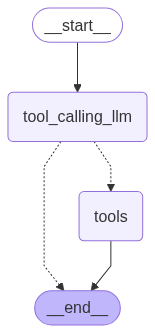

In [29]:
# Stategraph building
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

# Node defination
def tool_calling_llm(state: State):
    return {"messages" : [llm_with_tools.invoke(state["messages"])]}

# Graph
builder = StateGraph(State)
builder.add_node("tool_calling_llm",tool_calling_llm)  # Name, functionality
builder.add_node("tools", ToolNode(tools))

# Add edges
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    # If the latest message (result) from llm is a tool call -> tools_condition routes to tools
    # If the latest message (result) from llm is not a tool call -> tools_condition routes to END
    tools_condition
)
builder.add_edge("tools",END)

# Compile the graph
graph = builder.compile()
graph

In [30]:
response = graph.invoke({"messages": "What is the recent AI news"})

In [31]:
response['messages'][-1].content

'{"query": "recent AI news", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.infosecurity-magazine.com/news/defcon-ai-cyber-challenge-winners/", "title": "AI Cyber Challenge Winners Revealed in DARPA’s $4M Cybersecurity Showd - Infosecurity Magazine", "score": 0.7680558, "published_date": "Sat, 09 Aug 2025 10:45:00 GMT", "content": "1.   ### Microsoft 365 Copilot: New Zero-Click AI Vulnerability Allows Corporate Data Theft\\n\\nNews13 Jun 2025   \\n2.   ### Organizations Found to Address Only 21% of GenAI-Related Vulnerabilities\\n\\nNews15 Apr 2025   \\n3.   ### Google OSS-Fuzz Harnesses AI to Expose 26 Hidden Security Vulnerabilities\\n\\nNews21 Nov 2024   \\n4.   ### Google\'s Naptime Framework to Boost Vulnerability Research with AI\\n\\nNews25 Jun 2024   \\n5.   ### The Impact of AI on the Cybercrime Economy\\n\\nOpinion28 Dec 2018 [...] ### Chinese Smishing Campaigns Compromise up to 115 Million US Payment Cards\\n\\nNews5 Aug 2025\\n\\

In [32]:
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

What is the recent AI news
================================== Ai Message ==================================
Tool Calls:
  tavily_search (qzaz6xfsz)
 Call ID: qzaz6xfsz
  Args:
    end_date: None
    exclude_domains: []
    include_domains: []
    include_favicon: False
    include_images: False
    query: recent AI news
    search_depth: advanced
    start_date: None
    time_range: day
    topic: news
================================= Tool Message =================================
Name: tavily_search

{"query": "recent AI news", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.infosecurity-magazine.com/news/defcon-ai-cyber-challenge-winners/", "title": "AI Cyber Challenge Winners Revealed in DARPA’s $4M Cybersecurity Showd - Infosecurity Magazine", "score": 0.7680558, "published_date": "Sat, 09 Aug 2025 10:45:00 GMT", "content": "1.   ### Microsoft 365 Copilot: 

In [33]:
response1 = graph.invoke({"messages": 'What is 2 multiplied by 3'})
for i in response1['messages']:
    i.pretty_print()

================================ Human Message =================================

What is 2 multiplied by 3
================================== Ai Message ==================================
Tool Calls:
  multiply (y8bttd3mn)
 Call ID: y8bttd3mn
  Args:
    a: 2
    b: 3
================================= Tool Message =================================
Name: multiply

6
